In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import requests
import pyautogui
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\PC\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
import pyodbc
from pyodbc import ProgrammingError
import easyocr
import re
import mysql.connector
import pytesseract
from PIL import Image
from collections import deque
from mysql.connector import Error
import moviepy
from moviepy.editor import VideoFileClip

In [2]:
Server = "LAPTOP-HUBOG9MK\\LAW"
Database = "Minicapstone"

In [4]:
def detect_traffic_light_color(image, rect):
    # Extract rectangle dimensions
    x, y, w, h = rect
    # Extract region of interest (ROI) from the image based on the rectangle
    roi = image[y:y+h, x:x+w]
    
    # Convert ROI to HSV color space
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define HSV range for red color
    red_lower = np.array([0, 120, 70])
    red_upper = np.array([10, 255, 255])
    
    # Define HSV range for yellow color
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])

    # Create binary masks for detecting red and yellow in the ROI
    red_mask = cv2.inRange(hsv, red_lower, red_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    
    # Font details for overlaying text on the image
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2  
    
    # Check which color is present based on the masks
    if cv2.countNonZero(red_mask) > 0:
        text_color = (0, 0, 255)
        message = "Detected Signal Status: Stop"
        color = 'red'
    elif cv2.countNonZero(yellow_mask) > 0:
        text_color = (0, 255, 255)
        message = "Detected Signal Status: Caution"
        color = 'yellow'
    else:
        text_color = (0, 255, 0)
        message = "Detected Signal Status: Go"
        color = 'green'
        
    # Overlay the detected traffic light status on the main image
    cv2.putText(image, message, (15, 70), font, font_scale+0.5, text_color, font_thickness+1, cv2.LINE_AA)
    # Add a separator line
    cv2.putText(image, 34*'-', (10, 115), font, font_scale, (255,255,255), font_thickness, cv2.LINE_AA)
    
    # Return the modified image and detected color
    return image, color

In [25]:
class LineDetector:
    def __init__(self, num_frames_avg=10):
        # Initialize two deque queues to hold y-coordinate values across frames
        self.y_start_queue = deque(maxlen=num_frames_avg)
        self.y_end_queue = deque(maxlen=num_frames_avg)

    
    def detect_white_line(self, frame, color, 
                          slope1=0.03, intercept1=920, slope2=0.03, intercept2=770, slope3=-0.8, intercept3=2420):
        
        # Function to map color names to BGR values
        def get_color_code(color_name):
            color_codes = {
                'red': (0, 0, 255),
                'green': (0, 255, 0),
                'yellow': (0, 255, 255)
                 }
            return color_codes.get(color_name.lower())

        frame_org = frame.copy()
        
        # Line equations for defining region of interest (ROI)
        def line1(x): return slope1 * x + intercept1
        def line2(x): return slope2 * x + intercept2
        def line3(x): return slope3 * x + intercept3

        height, width, _ = frame.shape
        
        # Create a mask to spotlight the line's desired area
        mask1 = frame.copy()
        # Set pixels below the first line to black in mask1
        for x in range(width):
            y_line = line1(x)
            mask1[int(y_line):, x] = 0

        mask2 = mask1.copy()
        # Set pixels above the second line to black in mask2
        for x in range(width):
            y_line = line2(x)
            mask2[:int(y_line), x] = 0

        mask3 = mask2.copy()
        # Set pixels to the left of the third line to black in mask3 (final mask)
        for y in range(height):
            x_line = line3(y)
            mask3[y, :int(x_line)] = 0

        # Convert the mask to grayscale
        gray = cv2.cvtColor(mask3, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian filter to the ROI
        blurred_gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # Apply CLAHE to equalize the histogram
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_clahe = clahe.apply(blurred_gray)

        # Perform edge detection
        edges = cv2.Canny(gray, 30, 100)

        # Perform a dilation and erosion to close gaps in between object edges
        dilated_edges = cv2.dilate(edges, None, iterations=1)
        edges = cv2.erode(dilated_edges, None, iterations=1)

        # Perform Hough Line Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=160, maxLineGap=5)

        # Calculate x coordinates for the start and end of the line
        x_start = 0
        x_end = width - 1

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line parameters
                slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)  # Add a small number to avoid division by zero
                intercept = y1 - slope * x1

                # Calculate corresponding y coordinates
                y_start = int(slope * x_start + intercept)
                y_end = int(slope * x_end + intercept)

                # Add the y_start and y_end values to the queues
                self.y_start_queue.append(y_start)
                self.y_end_queue.append(y_end)

        # Compute the average y_start and y_end values
        avg_y_start = int(sum(self.y_start_queue) / len(self.y_start_queue)) if self.y_start_queue else 0
        avg_y_end = int(sum(self.y_end_queue) / len(self.y_end_queue)) if self.y_end_queue else 0

        
        # Draw the line
        line_start_ratio=0.32
        x_start_adj = x_start + int(line_start_ratio * (x_end - x_start))  # Adjusted x_start
        avg_y_start_adj = avg_y_start + int(line_start_ratio * (avg_y_end - avg_y_start))  # Adjusted avg_y_start

        # Create a mask with the same size as the frame and all zeros (black)
        mask = np.zeros_like(frame)

        x_start = 1300  # Your desired starting x-coordinate
        y_start = 1800 # Your desired starting y-coordinate
        x_end = 3500  # Your desired ending x-coordinate
        y_end = 2000 # Your desired ending y-coordinate
        
        # Draw the line on the mask
        cv2.line(mask, (x_start, y_start), (x_end, y_end), (255, 255, 255), 4)

        # Determine which color channel(s) to change based on the color argument
        color_code = get_color_code(color)
        if color_code == (0, 255, 0):  # Green
            channel_indices = [1]
        elif color_code == (0, 0, 255):  # Red
            channel_indices = [2]
        elif color_code == (0, 255, 255):  # Yellow
            # Yellow in BGR is a combination of green and red channels.
            # Here we modify both green and red channels.
            channel_indices = [1, 2]
        else:
            raise ValueError('Unsupported color')

        # Change the specified color channels of the frame where the mask is white
        for channel_index in channel_indices:
            frame[mask[:,:,channel_index] == 255, channel_index] = 255
                
                
        # Calculate slope and intercept for the average green line
        slope_avg = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
        intercept_avg = avg_y_start - slope_avg * x_start

        # Create a mask with the pixels above the green line set to black
        mask_line = np.copy(frame_org)
        for x in range(width):
            y_line = slope_avg * x + intercept_avg - 35
            mask_line[:int(y_line), x] = 0  # set pixels above the line to black

        return frame, mask_line

In [6]:
def extract_license_plate(frame, mask_line):    
    # Convert the image to grayscale (Haar cascades are typically trained on grayscale images)
    gray = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE to equalize the histogram
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Erode the image using a 2x2 kernel to remove noise
    kernel = np.ones((2, 2), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)

    # Find the bounding box of non-black pixels
    non_black_points = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(non_black_points)

    # Calculate the new width of the bounding box, excluding 30% on the right side
    w = int(w * 0.7)

    # Crop the image to the bounding box
    cropped_gray = gray[y:y+h, x:x+w]

    # Detect license plates in the image (this returns a list of rectangles)
    license_plates = license_plate_cascade.detectMultiScale(cropped_gray, scaleFactor=1.07, minNeighbors=15, minSize=(20, 20))

    # List to hold cropped license plate images
    license_plate_images = []

    # Loop over the license plates
    for (x_plate, y_plate, w_plate, h_plate) in license_plates:
        # Draw a rectangle around the license plate in the original frame (here you need the original coordinates)
        cv2.rectangle(frame, (x_plate + x, y_plate + y), (x_plate + x + w_plate, y_plate + y + h_plate), (0, 255, 0), 3)
    
        # Crop the license plate and append it to the list (here x_plate and y_plate are relative to cropped_gray)
        license_plate_image = cropped_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
        license_plate_images.append(license_plate_image)

    return frame, license_plate_images

In [7]:
def apply_ocr_to_image(license_plate_image):    
    # Threshold the image
    _, img = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)

    # Convert OpenCV image format to PIL Image format for pytesseract
    pil_img = Image.fromarray(img)

    # Use pytesseract to extract text from the image
    full_text = pytesseract.image_to_string(pil_img, config='--psm 6')

    return full_text.strip()  # Removing any extra white spaces from the ends

In [8]:
def draw_penalized_text(frame):
    # Set font, scale, thickness, and color
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2
    color = (255, 255, 255)  # White color
    
    # Initial position for Y-coordinate
    y_pos = 180
    
    # Put title on the frame
    cv2.putText(frame, 'Fined license plates:', (25, y_pos), font, font_scale, color, font_thickness)
    
    # Update Y-coordinate position
    y_pos += 80

    # Loop through all fined license plates
    for text in penalized_texts:
        # Add fined license plate text on the frame
        cv2.putText(frame, '->  '+text, (40, y_pos), font, font_scale, color, font_thickness)
        
        # Update Y-coordinate for next license plate
        y_pos += 60

In [9]:
def create_database_and_table(Server, Database):
    try:
        connection_str = (
            f"Driver={{SQL Server}};"
            f"Server={Server};"
            f"Trusted_Connection=yes;"
        )
    # Connect to the database (avoid creating one here)
    
        connection = pyodbc.connect(connection_str)
        print("Connected to SQL database Server:", Server, "\nDatabase: " + Database)

        # Create a new database cursor
        cursor = connection.cursor()

    except Error as e:
        print("Error while connecting to MySQL", e)
        return  # Exit the function if connection fails

    # **Separate `CREATE DATABASE` execution:**
    try:
        with connection.cursor() as create_cursor:
            create_cursor.execute(f"""
                IF NOT EXISTS (SELECT * FROM sys.databases WHERE name = N'{Database}')
                    CREATE DATABASE {Database};
            """)
        print(f"Database '{Database}' created successfully!")
    except Error as e:
        print("Error while creating database:", e)
        
    finally:
        connection.close()

    connection_st = ("Driver={SQL Server};"
                  "Server=" + Server + ";"
                  "Database=" + Database + ";"
                  "Trusted_Connection=yes;")
    try:
        connection = pyodbc.connect(connection_st)
        cursor = connection.cursor()
    except Error as e:
        print("Error while creating database:", e)
    # Create a new table
    try:
        # Create a new table
        with connection.cursor() as create_cursor:
            create_cursor.execute("""
                IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = 'license_plates')
                BEGIN
                    CREATE TABLE license_plates (
                        id INT IDENTITY(1, 1) PRIMARY KEY,
                        plate_number VARCHAR(255) NOT NULL UNIQUE,
                        violation_count INT DEFAULT 1
                    );
                END;
            """)
        print("Table 'license_plates' created successfully!")

    except ProgrammingError as e:
        print('Error while creating table:', e)

    finally:
        connection.close()

In [10]:
def update_database_with_violation(plate_number, Server, Database):
    try:
        connection_str = ("Driver={SQL Server};"
                          "Server=" + Server + ";"
                          "Database=" + Database + ";"
                          "Trusted_Connection=yes;")

        connection = pyodbc.connect(connection_str)
        cursor = connection.cursor()

        # Check if the license plate already exists in the table
        cursor.execute(f"SELECT violation_count FROM license_plates WHERE plate_number='{plate_number}'")
        result = cursor.fetchone()

        if result:
            # Increment violation_count by 1 if plate_number already exists
            current_violation_count = result[0]
            updated_violation_count = current_violation_count + 1
            cursor.execute(f"UPDATE license_plates SET violation_count=? WHERE plate_number=?", (updated_violation_count, plate_number))
        else:
            # Insert a new record if plate_number doesn't exist
            cursor.execute(f"INSERT INTO license_plates (plate_number, violation_count) VALUES (?, 1)", (plate_number,))

        # Commit changes (important to persist data)
        connection.commit()
        cursor.close()

    except Error as e:
        print("Error while connecting to SQL Server:", e)

    finally:
        if connection:
            connection.close()


In [11]:
def print_all_violations(Server, Database):
    
    try:
        
        connection_str = ("Driver={SQL Server};"
                      "Server=" + Server + ";"
                      "Database=" + Database + ";"
                      "Trusted_Connection=yes;")
    
        connection = pyodbc.connect(connection_str)
        
        cursor = connection.cursor()

        # Fetch all violations from the database
        cursor.execute("SELECT plate_number, violation_count FROM license_plates ORDER BY violation_count DESC")
        result = cursor.fetchall()
        
        print("\n")
        print("-"*66)
        print("\nAll Registered Traffic Violations in the Database:\n")
        for record in result:
            print(f"Plate Number: {record[0]}, Violations: {record[1]}")
        
        cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
            connection.close()

In [12]:
def clear_license_plates(Server, Database):

    try:
        
        connection_str = ("Driver={SQL Server};"
                      "Server=" + Server + ";"
                      "Database=" + Database + ";"
                      "Trusted_Connection=yes;")
    
        connection = pyodbc.connect(connection_str)
        cursor = connection.cursor()

        # Delete all records from the table
        cursor.execute("DELETE FROM license_plates")

        connection.commit()
        cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
            connection.close()

In [20]:
def main():
    # Ensure the database and table exist
    create_database_and_table(Server, Database)
    
    # Clear the license plates from the previous run. (Comment out this line if desired!)
    clear_license_plates(Server, Database)
    
    # Open the video file
    vid = cv2.VideoCapture('Test4.mp4')
 
    width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
    height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    
    # Create detector object
    detector = LineDetector()


    # Loop through each frame in the video
    while True:
        # Read frame
        ret, frame = vid.read()

        # Break if frame is not returned
        if not ret:
            break

        # Assuming rect is the rectangle where the traffic light is located
        rect = (3700, 40, 280, 600) 
        
        # Detect traffic light color
        frame, color = detect_traffic_light_color(frame, rect)
        
        # Detect white line
        frame, mask_line = detector.detect_white_line(frame, color)
        
        # Process the frame if the light is red
        if color == 'red':
            # Extract license plate
            frame, license_plate_images = extract_license_plate(frame, mask_line)
            
            # Process each detected license plate
            for license_plate_image in license_plate_images:
                # Apply OCR to the license plate image
                text = apply_ocr_to_image(license_plate_image)

                # Check if the license plate text is not empty, not already penalized, and matches the format
                if text and text not in penalized_texts and re.match("^[A-Z]{2}\s[0-9]{3,4}$", text):
                    penalized_texts.append(text)
                    # Print the fined license plate
                    print(f"\nFined license plate: {text}")

                    # Plot the license plate image
                    plt.figure()
                    plt.imshow(license_plate_image, cmap='gray')
                    plt.axis('off')
                    plt.show()

                    # Update the database with the license plate violation
                    try:
                        update_database_with_violation(text, Server, Database)
                    except pyodbc.Error as e:
                        print("An error occurred:", e)

        # Draw the penalized text onto the frame if there is any
        if penalized_texts:
            draw_penalized_text(frame)

        # Display the frame 
        frame = cv2.resize(frame, (int(width/2.3), int(height/2.3)))
        cv2.imshow('frame', frame)

        # Break if ESC key is pressed (uncomment the following line when running on a local system with GUI support)
        if cv2.waitKey(1) == 27:
            break

    # Release the video
    vid.release()
    
    # Close all OpenCV windows (uncomment the following line when running on a local system with GUI support)
    cv2.destroyAllWindows()

    # Print all the violations from the database
    print_all_violations(Server, Database)


In [14]:
%%capture
# Download the trained Haar Cascade from the GitHub repository
url = "https://raw.githubusercontent.com/FarzadNekouee/Traffic-Violation-Detection/master/haarcascade_russian_plate_number.xml"
response = requests.get(url)

with open('haarcascade_russian_plate_number.xml', 'wb') as file:
    file.write(response.content)

# Load the trained Haar Cascade
license_plate_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

# Create a list to store unique penalized license plate texts
penalized_texts = []

Connected to SQL database Server: LAPTOP-HUBOG9MK\LAW 
Database: Minicapstone
Database 'Minicapstone' created successfully!
Table 'license_plates' created successfully!

Fined license plate: YB 6433


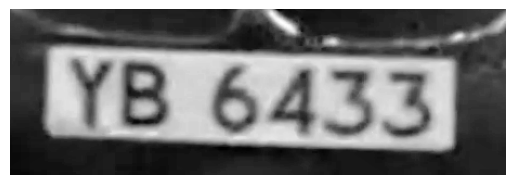



------------------------------------------------------------------

All Registered Traffic Violations in the Database:

Plate Number: YB 6433, Violations: 1


In [26]:
if __name__ == "__main__":
     main()